In [2]:
# PROCESS THE COMOVING STARS CATAOLOG:
# https://zenodo.org/records/4435257
# https://academic.oup.com/mnras/article/506/2/2269/6131876#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  JAN 2024 CREATE JUPYTER NOTEBOOK

In [3]:
# Define the metadata for the data set. 
metadata = {}

metadata['project'] = 'Digital Universe Atlas'
metadata['sub_project'] = 'Comoving Stars'

metadata['catalog'] = 'A million binaries from Gaia eDR3: sample selection and validation of Gaia parallax uncertainties (El-Badry+, 2021)'
metadata['author'] = 'El-Badry+'
metadata['prepared_by'] = 'Zack Reeves (AMNH)'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Comoving Stars'
metadata['data_group_desc'] = 'Comoving Star catalog'
metadata['fileroot'] = 'cm'

In [54]:
import pandas as pd
import numpy as np
import sys
import collections

from matplotlib import pyplot as plt, colors

from astroquery.gaia import Gaia
from astroquery.utils.tap.core import TapPlus

from astropy.io import fits
import astropy.table as table
from astropy.table import Table, vstack

sys.path.insert(0, '..')
from common import file_functions, calculations

In [ ]:
#running code with -i allows us to run the .py files in the same namespace as our .ipynb
%run -i el_badry_query.py

In [ ]:
#running code with -i allows us to run the .py files in the same namespace as our .ipynb
%run -i num_neighbors_edr3.py

In [ ]:
%run -i find_binaries_edr3.py

In [17]:
binaries = Table.read('raw_data/all_columns_catalog.fits')[['source_id1', 'source_id2', 'ra1', 'ra2', 'dec1', 'dec2', 'parallax1', 'parallax2', 'parallax_error1', 'parallax_error2', 'pmra1', 'pmra2', 'pmdec1', 'pmdec2', 'dr2_radial_velocity1', 'dr2_radial_velocity2']]

In [26]:
import find_binaries_edr3

KeyboardInterrupt: 

In [29]:
binaries

source_id1,source_id2,ra1,ra2,dec1,dec2,parallax1,parallax2,parallax_error1,parallax_error2,pmra1,pmra2,pmdec1,pmdec2,dr2_radial_velocity1,dr2_radial_velocity2
,,deg,deg,deg,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s
int64,int64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float32,float32
4282339100022417152,4282339095720590720,282.80943113005753,282.8088579357593,5.692464376105104,5.688739805905678,2.466308813127245,3.129725645547363,0.015508463,0.28737023,-18.500443947672455,-18.279317121880627,-14.406112556212221,-15.135270582024575,1e+20,1e+20
4089436931798712576,4089437344115586432,276.31365516286564,276.32563147342296,-23.55099339732246,-23.53250430327995,2.4230962227012838,2.92015611211368,0.089352295,0.23494595,-4.344694168896968,-3.844595829572494,-15.805990832000269,-15.86176044805748,1e+20,1e+20
4282722760856124416,4282722790916299648,283.2152167318123,283.19616572286793,5.949548004855735,5.946408290921299,1.043858388313062,1.129170131567232,0.074837394,0.20538272,-2.044045573754162,-2.223293512377718,-5.464987837879764,-5.082799378502095,1e+20,1e+20
4128188325747199104,4128188325747198080,256.87034730707893,256.8701664814668,-20.23579945116703,-20.23719657986973,1.6715541895959316,1.6474244682595314,0.016625766,0.026787495,-0.5260189837622264,-0.6637311157992818,-1.4130767700283122,-1.2128449819335219,1e+20,1e+20
4281789722159307520,4281789717861282176,285.41625509993867,285.4185112346541,5.741901784051386,5.736569021788802,6.792464103222925,6.910620412548305,0.03448111,0.59699315,58.48323610167057,58.73585293491805,54.8894404302667,55.45664965375919,1e+20,1e+20
4282724650641727872,4282724650639708544,283.2227851522741,283.2227363767862,5.9887962807392086,5.989005471747089,2.1027175948727366,2.2964277276341614,0.14107291,0.14666869,4.516002516901692,4.712677029185624,-13.312194163857983,-13.221949600208935,1e+20,1e+20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6056104140254764928,6056104140218598656,196.52615240256486,196.5253439679154,-59.88027328490403,-59.88042787590136,1.10706443247699,1.327634967498607,0.031662274,0.16524912,6.788454989504975,6.754170085496924,2.8269079569674913,2.9389286374903447,1e+20,1e+20


In [30]:
data_1 = binaries[['source_id1', 'ra1', 'dec1', 'parallax1', 'parallax_error1', 'pmra1', 'pmdec1', 'dr2_radial_velocity1']]

In [31]:
data_2 = binaries[['source_id2', 'ra2', 'dec2', 'parallax2', 'parallax_error2', 'pmra2', 'pmdec2', 'dr2_radial_velocity2']]

In [32]:
data_1.rename_columns(['source_id1', 'ra1', 'dec1', 'parallax1', 'parallax_error1', 'pmra1', 'pmdec1', 'dr2_radial_velocity1'], ['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'pmra', 'pmdec', 'dr2_radial_velocity']),
data_2.rename_columns(['source_id2', 'ra2', 'dec2', 'parallax2', 'parallax_error2', 'pmra2', 'pmdec2', 'dr2_radial_velocity2'], ['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'pmra', 'pmdec', 'dr2_radial_velocity'])

In [44]:
data_1['binary_index']=[str(i)+'_1' for i in range(len(binaries))]
data_2['binary_index']=[str(i)+'_2' for i in range(len(binaries))]

In [45]:
data = vstack([data_1, data_2])

In [46]:
#calculating distance in light years and parsecs
calculations.get_distance(data, parallax='parallax', use='parallax')

In [47]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', radial_velocity='dr2_radial_velocity', frame='icrs')

<function matplotlib.pyplot.show(close=None, block=None)>

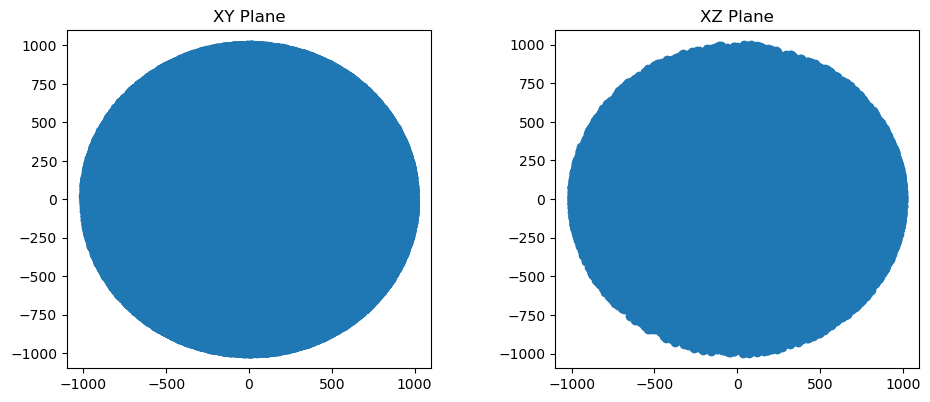

In [50]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

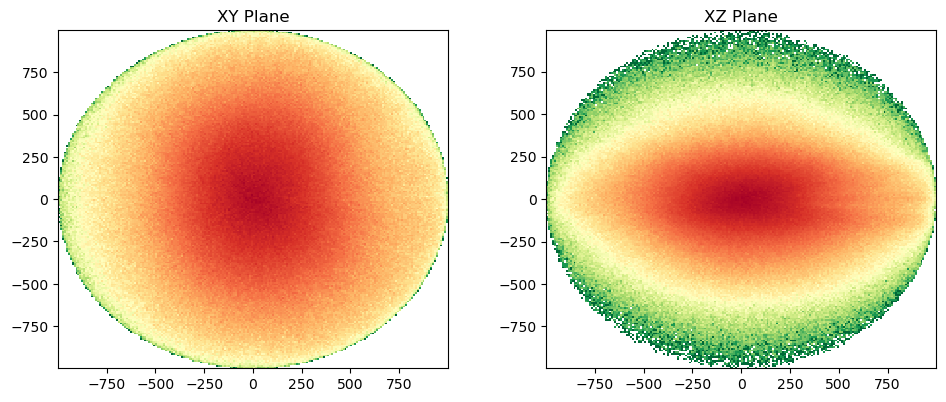

In [55]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [56]:
data['error_over_parallax']=[data['parallax_error'][i]/data['parallax'][i] for i in range(len(data))]

In [61]:
len(data[data['error_over_parallax']>0.15])

463821

In [62]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['source_id']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia EDR3 Source ID')

#construct a label column
data['label'] = ['GaiaEDR3_'+ str(source) for source in data['source_id']]  #leaving for now in case we want to add other labels

In [63]:
#construct a metadata table
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'dist_ly', 'u', 'v', 'w', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,Position (x coordinate) in pc
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in pc
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in pc
3,dist_ly,lyr,float64,,1,,pos.distance,Distance from Sun (lyr)
4,u,km / s,float64,,6,,vel.cartesian.u,Heliocentric velocity towards Galactic Center
5,v,km / s,float64,,6,,vel.cartesian.v,Heliocentric velocity towards Galactic Rotation
6,w,km / s,float64,,6,,vel.cartesian.w,Heliocentric velocity towards Galactic North Pole
7,speck_label,,str,,,*,meta.id,Gaia EDR3 Source ID


In [64]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [65]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))